In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Collecting

In [106]:
df = sns.load_dataset("titanic")

In [107]:
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Preprocessing

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


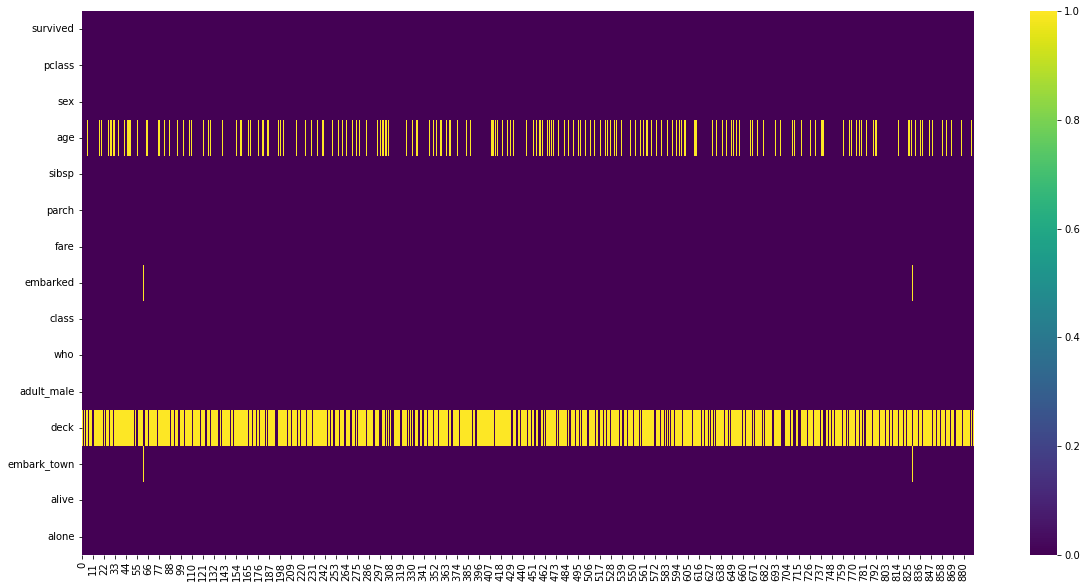

In [109]:
# White lines are nan values
nan_values_transpose = df.isna().transpose().copy()
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(nan_values_transpose, ax = ax, cmap = "viridis")
plt.show()

# this graph shows:
#  - we should drop deck column.
#  - fill nan values for age if it possible.
#  - and drop rows with nan values at the end.

In [110]:
# drop deck column because it is full of nan values!
df.drop(["deck"], axis = 1, inplace = True)

# drop useless columns 
df.drop(["who","class","adult_male","embarked","alive","alone"], axis = 1, inplace = True)

In [111]:
# replacing women with 1 and men with 0
df["sex"] = np.where(df.sex == "female", 1, 0)

In [112]:
# see correlation for age to find out that based on which column we should fill missing value of age
df.corr()["age"].sort_values()
# result shows pclass and silbsp medium correlation with age, lets zoom on them

pclass     -0.369226
sibsp      -0.308247
parch      -0.189119
sex        -0.093254
survived   -0.077221
fare        0.096067
age         1.000000
Name: age, dtype: float64

In [113]:
# check that if we can fill nan ages just using their pclass parameter
pclass_age = df.groupby(["pclass"])["age"].agg(["mean", "median","min","max","count"])
pclass_age
# it's not bad. but all mean ages are high in this case

,mean,median,min,max,count
pclass,,,,,
1,38.233441,37.0,0.92,80.0,186
2,29.877630,29.0,0.67,70.0,173
3,25.140620,24.0,0.42,74.0,355


In [114]:
# check that if we can fill nan ages just using their silbsp parameter
sibsp_age = df.groupby(["sibsp"])["age"].agg(["mean", "median","min","max","count"])
sibsp_age
# it's good i think

,mean,median,min,max,count
sibsp,,,,,
0,31.397558,29.0,0.42,80.0,471
1,30.089727,30.0,0.67,70.0,183
2,22.620000,23.0,0.75,53.0,25
3,13.916667,9.5,2.00,33.0,12
4,7.055556,6.5,1.00,17.0,18
5,10.200000,11.0,1.00,16.0,5
8,NaN,NaN,NaN,NaN,0


In [115]:
# check that if we can fill nan ages using their pclass and sibsp parameter
pclass_sibsp_age = df.groupby(["pclass","sibsp"])["age"].agg(["mean", "median","min","max","count"])
pclass_sibsp_age
# it is not good because there are a lot of diffrent case 

mean  median    min   max  count
pclass sibsp                                       
1      0      39.181416    37.0   4.00  80.0    113
       1      37.414154    38.0   0.92  70.0     65
       2      37.200000    44.0  18.00  53.0      5
       3      22.000000    23.0  19.00  24.0      3
2      0      31.934220    30.0   0.83  70.0    109
       1      27.363636    29.0   0.67  60.0     55
       2      19.125000    23.5   1.00  32.0      8
       3      30.000000    30.0  30.00  30.0      1
3      0      27.630201    26.0   0.42  74.0    249
       1      24.912698    25.0   1.00  48.0     63
       2      18.875000    19.5   0.75  41.0     12
       3       8.875000     6.0   2.00  33.0      8
       4       7.055556     6.5   1.00  17.0     18
       5      10.200000    11.0   1.00  16.0      5
       8            NaN     NaN    NaN   NaN      0

In [116]:
# mean age used in `else` in next cell
df.age.mean()

29.69911764705882

In [117]:
# fill nan values in age column based on their sibsp parameter
def fill_nan_age(x):
    if (x == 0):
        return 32
    elif (x == 1):
        return 30
    elif (x == 2):
        return 23
    elif (x == 3):
        return 14
    elif (x == 4):
        return 7
    elif (x == 5):
        return 10
    else:
        return 30

In [118]:
# apply fill_nan_age function
df["age"] = df.apply(lambda x : fill_nan_age(x.sibsp) if pd.isnull(x.age) else x.age, axis = 1 )

In [119]:
# drop rows that contains nan value. there are just two of them that have nan values in embark_town column
df = df.dropna().reset_index(drop = True)

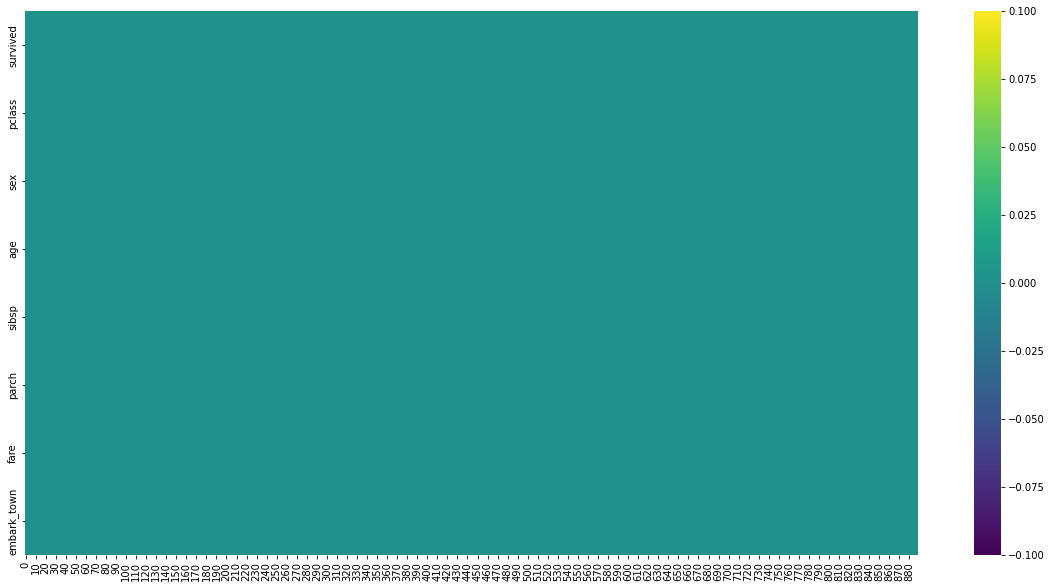

In [120]:
nan_values_transpose_final = df.isna().transpose().copy()
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(nan_values_transpose_final, ax = ax, cmap = "viridis")
plt.show()
# there are no nan values at all

In [121]:
# Convert categorical variable ( embark_town ) into dummy variables
df = pd.get_dummies(df, columns = ["embark_town"], drop_first = True)

In [122]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town_Queenstown,embark_town_Southampton
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1


# Visualization

In [123]:
# find strong correlations for "survived" column 
df.corr()["survived"].sort_values(ascending = False)
# it is show that sex,fare and pclass are important features

survived                   1.000000
sex                        0.541585
fare                       0.255290
parch                      0.083151
embark_town_Queenstown     0.004536
sibsp                     -0.034040
age                       -0.077954
embark_town_Southampton   -0.151777
pclass                    -0.335549
Name: survived, dtype: float64

In [124]:
# sex = 1 = female
# sex = 0 = male
# bigger bubble means lower pclass. ex: pclass = 3 is the worst pclass and they are biggest bubbles our scatter plot 

scatter = px.scatter(df, x = "fare", y = "survived", color = "sex", size = "pclass")
scatter.show()


# Prediction

In [125]:
# cut off the target column
y = df["survived"]
X = df.drop(["survived"], axis = 1)

In [126]:
# train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [127]:
# Normalization

age_scaler = MinMaxScaler()
fare_scaler = MinMaxScaler()

age_scaler.fit(np.reshape(X_train.age.values,(-1,1)))
X_train["age"] = np.squeeze(age_scaler.transform(np.reshape(X_train.age.values,(-1,1))))
X_test["age"] = np.squeeze(age_scaler.transform(np.reshape(X_test.age.values,(-1,1))))


fare_scaler.fit(np.reshape(X_train.fare.values,(-1,1)))
X_train["fare"] = np.squeeze(fare_scaler.transform(np.reshape(X_train.fare.values,(-1,1))))
X_test["fare"] = np.squeeze(fare_scaler.transform(np.reshape(X_test.fare.values,(-1,1))))

In [149]:
models_result = []

In [148]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [150]:
lgreg = LogisticRegression(max_iter = 200)
lgreg.fit(X_train, y_train)
prediction_lgreg = lgreg.predict(X_test)
score_lgreg = f1_score(y_test,prediction_lgreg)
print(f"score of LogisticRegression: {score_lgreg}")
models_result.append(["LogisticRegression", score_lgreg])


score of LogisticRegression: 0.7596899224806201


In [151]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
prediction_rfc = rfc.predict(X_test)
score_rfc = f1_score(y_test,prediction_rfc)
print(f"score of RandomForestClassifier: {score_rfc}")
models_result.append(["RandomForestClassifier", score_rfc])


score of RandomForestClassifier: 0.7596899224806201


In [152]:
svc = SVC()
svc.fit(X_train, y_train)
prediction_svc = svc.predict(X_test)
score_svc = f1_score(y_test,prediction_svc)
print(f"score of SVC: {score_svc}")
models_result.append(["SVC", score_svc])


score of SVC: 0.7751937984496124


0.7596899224806201
